In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.gen_short import MEL_Generator_Short, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    prepare_dataset,
)

In [2]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 50

In [3]:
al_audio_init = pd.read_csv("/app/_data/all_audio_initial.csv")
train_sound = pd.read_csv("/app/_data/train_soundscapes_prepared.csv")
distances_df = pd.read_csv("/app/_data/distances.csv")
all_audio = pd.read_csv("/app/_data/all_audio_initial_distance.csv")
coord_sites = pd.read_csv("/app/_data/coord_sites.csv")
dates_sites = pd.read_csv("/app/_data/dates_sites.csv", parse_dates=[5, 6])
dates = pd.read_csv("/app/_data/test_soundscapes/test_set_recording_dates.csv")
train_sound = prepare_dataset(train_sound)

In [4]:
al_audio_init[al_audio_init['file_path'].str.contains('SNE')]

,primary_label,secondary_labels,latitude,longitude,date,filename,rating,month,year,file_path,...,cos_month,sin_longitude,cos_longitude,norm_latitude,label_id,class_weights,num_intervals,start_sec,end_sec,secondary_labels_id


In [5]:
dates["date"] = pd.to_datetime(dates["date"], format="%Y%m%d")
dates["month"] = dates["date"].dt.month
dates["year"] = dates["date"].dt.year

In [6]:
sites = dates_sites[["site", "min_month", "max_month", "min_year"]].merge(
    coord_sites[["latitude", "longitude", "site"]], on="site"
)
sites

,site,min_month,max_month,min_year,latitude,longitude
0,COL,9,11,2019,5.57,-75.85
1,COR,9,10,2019,10.12,-84.51
2,SNE,5,5,2018,38.49,-119.95
3,SSW,2,8,2017,42.47,-76.45


In [7]:
def choose_ids(distance_delta=500, start_year=2007):
    import pandas as pd

    df = distances_df.query(
        "dist_COR <= @distance_delta or dist_SNE <= @distance_delta or dist_SSW <= @distance_delta or dist_COL <= @distance_delta"
    )
    list_filenames = df.query("year >= @start_year")["filename"].unique().tolist()
    return list_filenames

In [8]:
list_filenames = choose_ids(1000)

In [9]:
for distance_delta in [500, 600, 700, 800, 900, 1000]:
    list_filenames = choose_ids(distance_delta, start_year=2010)
    audio_df = all_audio.query("filename in @list_filenames")
    COR_500 = audio_df[audio_df["dist_COR"] <= distance_delta]
    COL_500 = audio_df[audio_df["dist_COL"] <= distance_delta]
    SNE_500 = audio_df[audio_df["dist_SNE"] <= distance_delta]
    SSW_500 = audio_df[audio_df["dist_SSW"] <= distance_delta]
    #     cor_monts = [8, 9, 10, 11]
    #     col_monts = [8, 9, 10, 11, 12]
    #     sne_monts = [4, 5, 6]
    #     ssw_monts = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    cor_monts = [7, 8, 9, 10, 11, 12]
    col_monts = [7, 8, 9, 10, 11, 12, 1]
    sne_monts = [3, 4, 5, 6, 7]
    ssw_monts = [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    print(
        distance_delta,
        "cor",
        COR_500.query("month in @cor_monts").primary_label.unique().shape,
        "col",
        COL_500.query("month in @col_monts").primary_label.unique().shape,
        "sne",
        SNE_500.query("month in @sne_monts").primary_label.unique().shape,
        "ssw",
        SSW_500.query("month in @ssw_monts").primary_label.unique().shape,
    )

500 cor (219,) col (192,) sne (184,) ssw (169,)
600 cor (222,) col (198,) sne (192,) ssw (173,)
700 cor (250,) col (223,) sne (203,) ssw (174,)
800 cor (259,) col (225,) sne (217,) ssw (176,)
900 cor (267,) col (227,) sne (223,) ssw (179,)
1000 cor (280,) col (259,) sne (233,) ssw (183,)


2012  
500 cor (192,) col (182,) sne (170,) ssw (163,)  
600 cor (199,) col (186,) sne (178,) ssw (167,)  
700 cor (226,) col (210,) sne (188,) ssw (170,)  
800 cor (242,) col (214,) sne (201,) ssw (173,)  
900 cor (251,) col (216,) sne (209,) ssw (176,)  
1000 cor (260,) col (251,) sne (224,) ssw (180,)  

2010  
500 cor (192,) col (182,) sne (171,) ssw (163,)  
600 cor (199,) col (186,) sne (180,) ssw (168,)   
700 cor (226,) col (210,) sne (188,) ssw (171,)  
800 cor (242,) col (214,) sne (202,) ssw (173,)  
900 cor (251,) col (216,) sne (209,) ssw (176,)  
1000 cor (260,) col (251,) sne (224,) ssw (180,)  

2007  
500 cor (193,) col (184,) sne (171,) ssw (167,)  
600 cor (200,) col (188,) sne (180,) ssw (169,)  
700 cor (227,) col (212,) sne (188,) ssw (172,)  
800 cor (242,) col (216,) sne (202,) ssw (174,)  
900 cor (252,) col (218,) sne (209,) ssw (177,)  
1000 cor (261,) col (252,) sne (224,) ssw (181,)  

In [21]:
distance_delta = 600
list_filenames = choose_ids(distance_delta, start_year=2010)
audio_df = all_audio.query("filename in @list_filenames")
COR_600 = audio_df[audio_df["dist_COR"] <= distance_delta]
COL_600 = audio_df[audio_df["dist_COL"] <= distance_delta]
SNE_600 = audio_df[audio_df["dist_SNE"] <= distance_delta]
SSW_600 = audio_df[audio_df["dist_SSW"] <= distance_delta]
cor_monts = [8, 9, 10, 11]
col_monts = [8, 9, 10, 11, 12]
sne_monts = [4, 5, 6]
ssw_monts = [1, 2, 3, 4, 5, 6, 7, 8, 9]
print(
    distance_delta,
    "cor",
    COR_600.query("month in @cor_monts").primary_label.unique().shape,
    "col",
    COL_600.query("month in @col_monts").primary_label.unique().shape,
    "sne",
    SNE_600.query("month in @sne_monts").primary_label.unique().shape,
    "ssw",
    SSW_600.query("month in @ssw_monts").primary_label.unique().shape,
)

600 cor (199,) col (186,) sne (180,) ssw (168,)


In [22]:
COR_600.primary_label.unique().shape

(247,)

In [23]:
list_cor = COR_600.query("month in @cor_monts").primary_label.unique()

## Geodata

In [24]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

In [25]:
gdf_coord_sites = geopandas.GeoDataFrame(
    coord_sites,
    geometry=geopandas.points_from_xy(coord_sites.longitude, coord_sites.latitude),
)

In [26]:
gdf_COR_600 = geopandas.GeoDataFrame(
    COR_600, geometry=geopandas.points_from_xy(COR_600.longitude, COR_600.latitude)
)
gdf_COR_600_all_birds = geopandas.GeoDataFrame(
    al_audio_init.query("primary_label in @list_cor"),
    geometry=geopandas.points_from_xy(
        al_audio_init.query("primary_label in @list_cor").longitude,
        al_audio_init.query("primary_label in @list_cor").latitude,
    ),
)
gdf_COL_600 = geopandas.GeoDataFrame(
    COL_600, geometry=geopandas.points_from_xy(COL_600.longitude, COL_600.latitude)
)
gdf_SNE_600 = geopandas.GeoDataFrame(
    SNE_600, geometry=geopandas.points_from_xy(SNE_600.longitude, SNE_600.latitude)
)
gdf_SSW_600 = geopandas.GeoDataFrame(
    SSW_600, geometry=geopandas.points_from_xy(SSW_600.longitude, SSW_600.latitude)
)
all_ = geopandas.GeoDataFrame(
    al_audio_init,
    geometry=geopandas.points_from_xy(al_audio_init.longitude, al_audio_init.latitude),
)

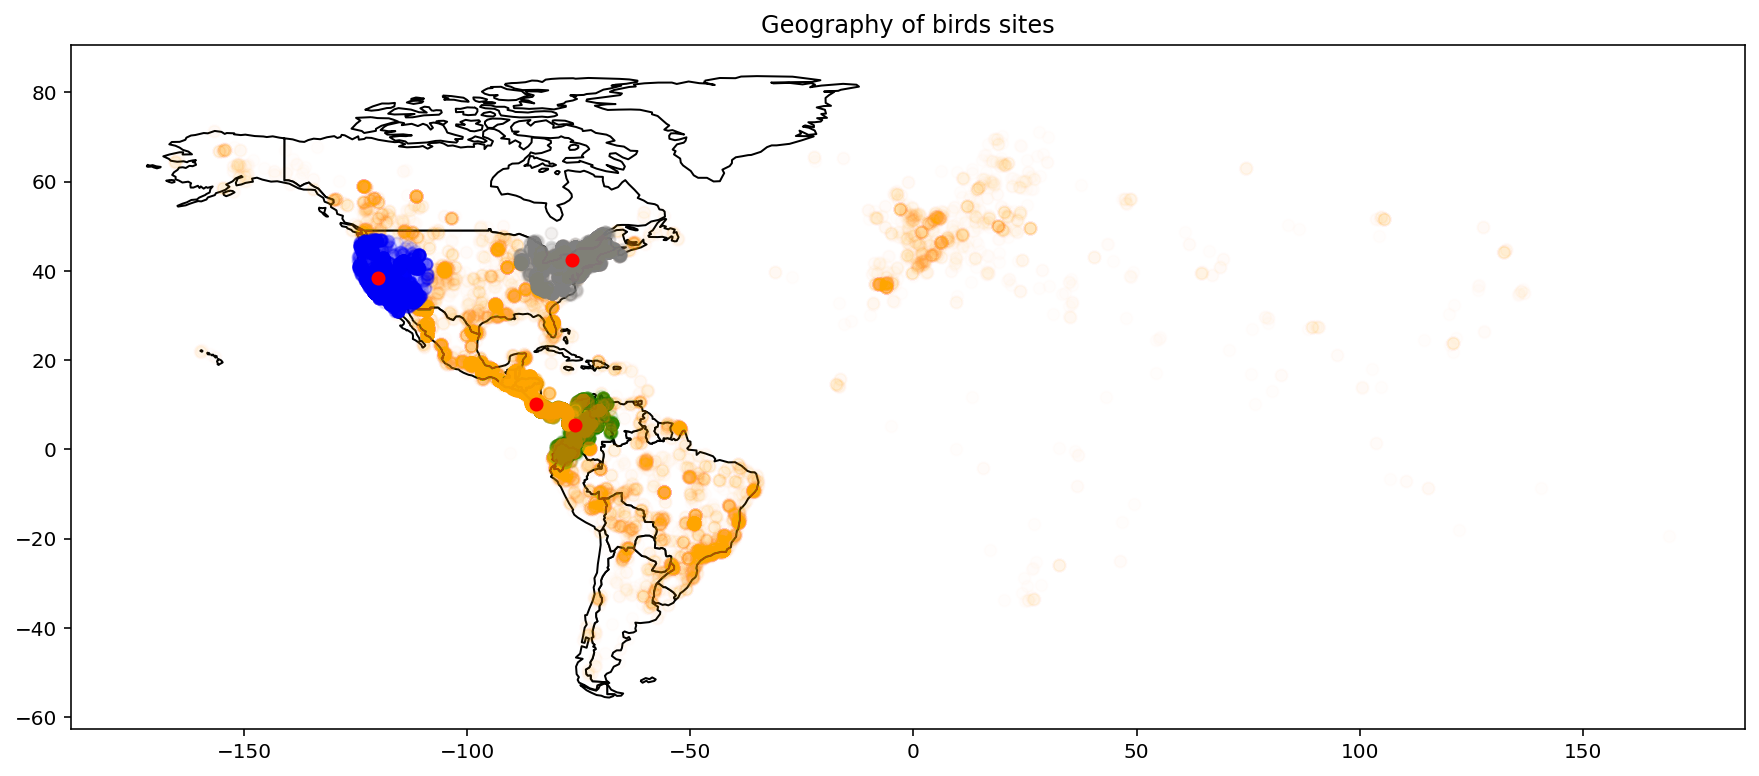

In [27]:
ax = world.query('continent == "North America" or continent == "South America"').plot(
    color="white", edgecolor="black", figsize=(15, 15)
)
plt.title("Geography of birds sites")
# all_.plot(ax=ax, categorical=True, label="all", color='magenta', alpha=0.01)
gdf_COL_600.plot(ax=ax, categorical=True, label="COL_600", color="green", alpha=0.1)
gdf_COR_600.plot(ax=ax, categorical=True, label="COR_600", color="orange", alpha=0.1)
gdf_COR_600_all_birds.plot(
    ax=ax, categorical=True, label="COR_600_all", color="orange", alpha=0.01
)

gdf_SNE_600.plot(ax=ax, categorical=True, label="SNE_600", color="blue", alpha=0.1)
gdf_SSW_600.plot(ax=ax, categorical=True, label="SSW_600", color="gray", alpha=0.1)
gdf_coord_sites.plot(ax=ax, categorical=True, color="r", label="test sites")
plt.show();

## dataframes

In [14]:
distance_delta = 600
cor_monts = [8, 9, 10, 11]
col_monts = [8, 9, 10, 11, 12]
sne_monts = [4, 5, 6]
ssw_monts = [1, 2, 3, 4, 5, 6, 7, 8, 9]
list_filenames = choose_ids(distance_delta, start_year=2010)
audio_df = all_audio.query("filename in @list_filenames")
COR_600 = audio_df[audio_df["dist_COR"] <= distance_delta].query("month in @cor_monts")
COL_600 = audio_df[audio_df["dist_COL"] <= distance_delta].query("month in @col_monts")
SNE_600 = audio_df[audio_df["dist_SNE"] <= distance_delta].query("month in @sne_monts")
SSW_600 = audio_df[audio_df["dist_SSW"] <= distance_delta].query("month in @ssw_monts")

print(
    distance_delta,
    "cor",
    COR_600.primary_label.unique().shape,
    "col",
    COL_600.primary_label.unique().shape,
    "sne",
    SNE_600.primary_label.unique().shape,
    "ssw",
    SSW_600.primary_label.unique().shape,
)

600 cor (199,) col (186,) sne (180,) ssw (168,)


In [15]:
birds_COR_600 = COR_600.primary_label.unique().tolist()
birds_COL_600 = COL_600.primary_label.unique().tolist()
birds_SNE_600 = SNE_600.primary_label.unique().tolist()
birds_SSW_600 = SSW_600.primary_label.unique().tolist()

In [30]:
np.save('/app/sandbox/sites/birds_COR_600',np.array(birds_COR_600))
np.save('/app/sandbox/sites/birds_COL_600',np.array(birds_COL_600))
np.save('/app/sandbox/sites/birds_SNE_600',np.array(birds_SNE_600))
np.save('/app/sandbox/sites/birds_SSW_600',np.array(birds_SSW_600))

# 500miles

In [40]:
distance_delta = 500
list_filenames = choose_ids(distance_delta=300, start_year=2013)
cor_monts = [8, 9, 10, 11]
col_monts = [8, 9, 10, 11, 12]
sne_monts = [4, 5, 6]
ssw_monts = [1, 2, 3, 4, 5, 6, 7, 8, 9]
audio_df = all_audio.query("filename in @list_filenames")
COR_300 = audio_df[audio_df["dist_COR"] <= distance_delta].query("month in @cor_monts")
COL_300 = audio_df[audio_df["dist_COL"] <= distance_delta].query("month in @col_monts")
SNE_300 = audio_df[audio_df["dist_SNE"] <= distance_delta].query("month in @sne_monts")
SSW_300 = audio_df[audio_df["dist_SSW"] <= distance_delta].query("month in @ssw_monts")

print(
    distance_delta,
    "cor",
    COR_300.query("month in @cor_monts").primary_label.unique().shape,
    "col",
    COL_300.query("month in @col_monts").primary_label.unique().shape,
    "sne",
    SNE_300.query("month in @sne_monts").primary_label.unique().shape,
    "ssw",
    SSW_300.query("month in @ssw_monts").primary_label.unique().shape,
)

500 cor (132,) col (160,) sne (144,) ssw (155,)


In [41]:
birds_COR_300 = COR_300.primary_label.unique().tolist()
birds_COL_300 = COL_300.primary_label.unique().tolist()
birds_SNE_300 = SNE_300.primary_label.unique().tolist()
birds_SSW_300 = SSW_300.primary_label.unique().tolist()

In [42]:
np.save('/app/sandbox/sites/birds_COR_300',np.array(birds_COR_300))
np.save('/app/sandbox/sites/birds_COL_300',np.array(birds_COL_300))
np.save('/app/sandbox/sites/birds_SNE_300',np.array(birds_SNE_300))
np.save('/app/sandbox/sites/birds_SSW_300',np.array(birds_SSW_300))

In [43]:
len(birds_COR_300)

132